In [56]:
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as srn
from datetime import datetime
from statsmodels.graphics.api import qqplot
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']= 10,6
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [57]:
o=pd.read_csv("o.csv",index_col=[0],parse_dates=[0]) #load dataset
o['pub_date']=pd.to_datetime(o['pub_date'],infer_datetime_format=True)
o.head()

,Unnamed: 0.1,pub_date,actual,forecast,previous,rolling_std,z-score,1,5,6,7
1,1,2008-03-26,0.1,1.7,0.1,3.888785,-0.411440,72.940002,59.943302,23198900.0,0.053213
2,2,2008-04-02,7.3,2.3,0.1,3.109845,1.607797,75.430000,61.676708,21192000.0,0.028507
3,3,2008-04-09,-3.1,2.3,7.3,3.538222,-1.526190,78.519997,63.490719,19490100.0,0.028987
4,4,2008-04-16,-2.4,1.8,-3.1,3.801634,-1.104788,80.199997,66.433479,22189100.0,0.045307
5,5,2008-04-23,2.4,1.5,-2.4,3.771866,0.238609,84.410004,67.658936,21763500.0,0.018278


In [58]:
o.drop(["Unnamed: 0.1"],axis=1,inplace=True) #drop column 'unnamed'
o.head() #displays first 5 observations

,pub_date,actual,forecast,previous,rolling_std,z-score,1,5,6,7
1,2008-03-26,0.1,1.7,0.1,3.888785,-0.411440,72.940002,59.943302,23198900.0,0.053213
2,2008-04-02,7.3,2.3,0.1,3.109845,1.607797,75.430000,61.676708,21192000.0,0.028507
3,2008-04-09,-3.1,2.3,7.3,3.538222,-1.526190,78.519997,63.490719,19490100.0,0.028987
4,2008-04-16,-2.4,1.8,-3.1,3.801634,-1.104788,80.199997,66.433479,22189100.0,0.045307
5,2008-04-23,2.4,1.5,-2.4,3.771866,0.238609,84.410004,67.658936,21763500.0,0.018278


In [59]:
o.tail() #displays last 5 observations

,pub_date,actual,forecast,previous,rolling_std,z-score,1,5,6,7
521,2018-04-11,3.3,-0.6,-4.6,3.260264,1.196222,69.800003,70.639999,21190900.0,0.047248
522,2018-04-18,-1.1,-0.5,3.3,3.260264,-0.184034,73.050003,73.559998,17311500.0,0.040505
523,2018-04-25,2.2,-1.6,-1.1,2.795275,1.359437,72.730003,73.540001,13163300.0,-0.000272
524,2018-05-02,6.2,1.0,2.2,3.178622,1.635929,73.139999,73.660004,13434700.0,0.001630
525,2018-05-09,-2.2,-0.2,6.2,3.327662,-0.601023,75.440002,76.050003,24903900.0,0.031931


In [60]:
o.columns=["pub_date","actual","forecast","previous","rolling_std","z-score","open","close","volume","log difference"] #change column names

In [61]:
o.set_index(['pub_date'],inplace=True) #set date column as index column

In [62]:
o.head()

,actual,forecast,previous,rolling_std,z-score,open,close,volume,log difference
pub_date,,,,,,,,,
2008-03-26,0.1,1.7,0.1,3.888785,-0.411440,72.940002,59.943302,23198900.0,0.053213
2008-04-02,7.3,2.3,0.1,3.109845,1.607797,75.430000,61.676708,21192000.0,0.028507
2008-04-09,-3.1,2.3,7.3,3.538222,-1.526190,78.519997,63.490719,19490100.0,0.028987
2008-04-16,-2.4,1.8,-3.1,3.801634,-1.104788,80.199997,66.433479,22189100.0,0.045307
2008-04-23,2.4,1.5,-2.4,3.771866,0.238609,84.410004,67.658936,21763500.0,0.018278


In [63]:
o.describe() #describes the data

,actual,forecast,previous,rolling_std,z-score,open,close,volume,log difference
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,5.250000e+02,525.000000
mean,0.329714,0.267619,0.329524,3.687490,0.031940,69.852895,62.113662,1.995153e+07,0.000555
std,4.195958,1.894664,4.194983,0.956056,0.964733,12.396326,12.162823,1.161432e+07,0.034878
min,-14.500000,-5.200000,-14.500000,1.276002,-3.268550,39.639999,32.721085,3.686600e+06,-0.163672
25%,-2.500000,-1.300000,-2.500000,2.996703,-0.585247,62.360001,54.990746,1.208220e+07,-0.016495
50%,0.600000,0.600000,0.600000,3.630928,0.000000,69.830002,63.669426,1.714430e+07,0.003178
75%,2.800000,1.700000,2.800000,4.374305,0.676627,77.830002,69.832802,2.405650e+07,0.020389
max,14.400000,5.000000,14.400000,7.128448,3.350538,100.099998,90.406898,8.049820e+07,0.113877


In [64]:
o.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 2008-03-26 to 2018-05-09
Data columns (total 9 columns):
actual            525 non-null float64
forecast          525 non-null float64
previous          525 non-null float64
rolling_std       525 non-null float64
z-score           525 non-null float64
open              525 non-null float64
close             525 non-null float64
volume            525 non-null float64
log difference    525 non-null float64
dtypes: float64(9)
memory usage: 41.0 KB


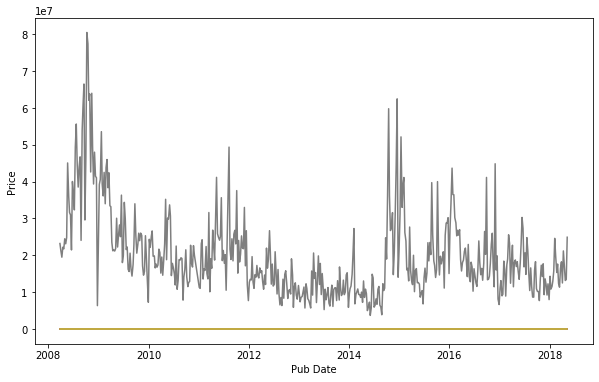

In [65]:
plt.xlabel("Pub Date")
plt.ylabel("Price")
plt.plot(o)

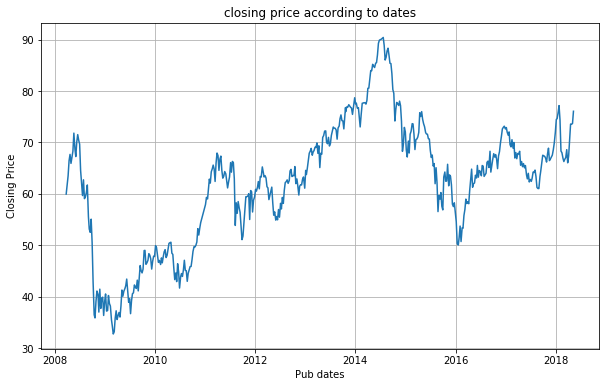

In [66]:
#plot closing price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Pub dates')
plt.ylabel('Closing Price')
plt.plot(o['close'])
plt.title('closing price according to dates')
plt.show()

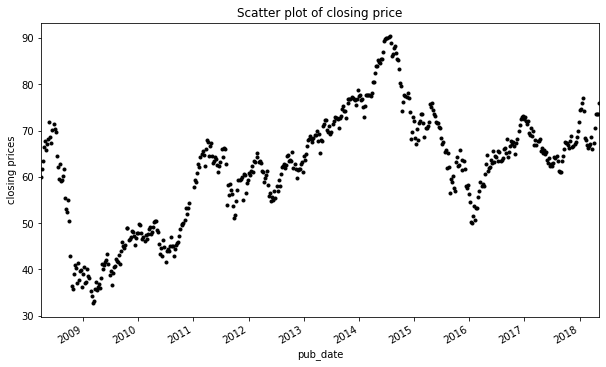

In [67]:
df_close2 = o['close'] #dataframe containing columnn 'close'
df_close2.plot(style='k.')
plt.ylabel('closing prices')
plt.title('Scatter plot of closing price')
plt.show()

C:\Users\Chandra Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 720x432 with 0 Axes>

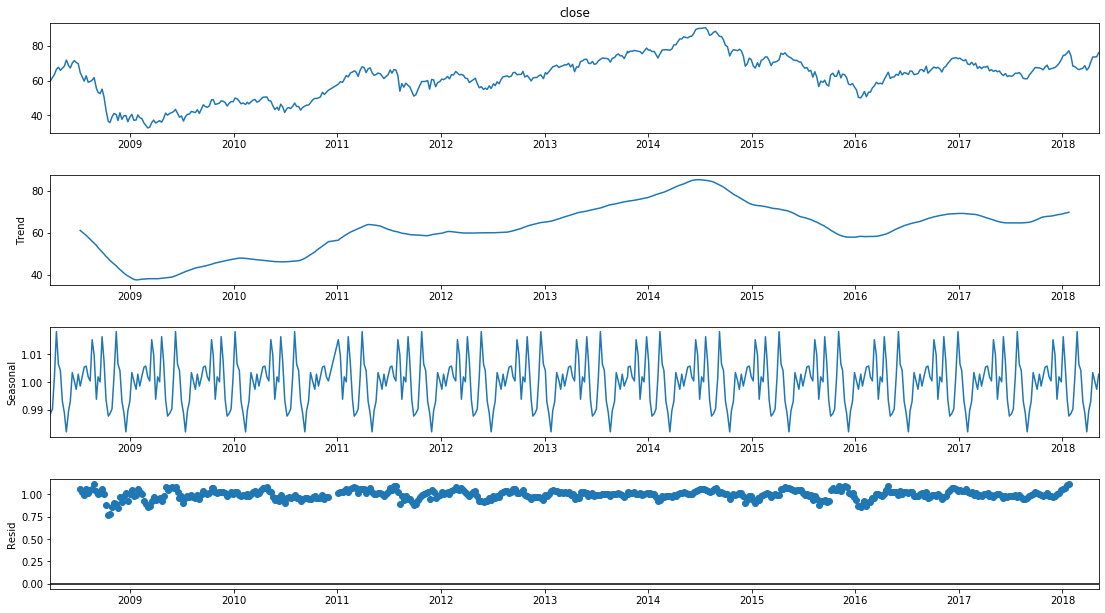

In [68]:
result = seasonal_decompose(df_close2, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [69]:
#rolling statistics
rolmean=o.rolling(window=12).mean() #rolling mean 
rolstd= o.rolling(window=12).std() #rolling standard deviation
print(rolmean,rolstd)

              actual  forecast  previous  rolling_std   z-score       open  \
pub_date                                                                     
2008-03-26       NaN       NaN       NaN          NaN       NaN        NaN   
2008-04-02       NaN       NaN       NaN          NaN       NaN        NaN   
2008-04-09       NaN       NaN       NaN          NaN       NaN        NaN   
2008-04-16       NaN       NaN       NaN          NaN       NaN        NaN   
2008-04-23       NaN       NaN       NaN          NaN       NaN        NaN   
...              ...       ...       ...          ...       ...        ...   
2018-04-11  1.325000  1.533333  0.475000     4.164410 -0.026737  69.315000   
2018-04-18  1.325000  1.575000  1.325000     4.165777 -0.039505  68.902501   
2018-04-25  0.941667  1.433333  1.325000     4.053674 -0.061065  68.713334   
2018-05-02  1.300000  1.250000  0.941667     3.973516  0.101427  68.959167   
2018-05-09  0.966667  1.000000  1.300000     3.885900  0.070372 

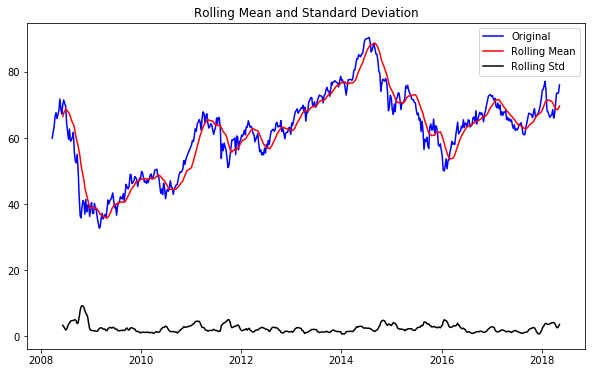

Results of dickey fuller test
Test Statistics                 -1.551870
p-value                          0.507714
No. of lags used                 1.000000
Number of observations used    523.000000
critical value (1%)             -3.442915
critical value (5%)             -2.867082
critical value (10%)            -2.569722
dtype: float64


In [70]:
#Test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(o):
    #Determing rolling statistics
    rolmean = o.rolling(12).mean()
    rolstd = o.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(o, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(o, maxlag=1,autolag= None) #augmented dickey fuller test to check stationarity of data
    # output for adft will give us values without defining them.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close2)

In [71]:
#The Null Hypothesis in ADF test states that the time-series data is non-stationary whereas, the Alternative Hypothesis states that the time-series data is stationary.
#The P-value given above is 0.507714 which is greater than the level of significance:alpha=0.05.
#Therefore we fail to reject the Null Hypothesis and conclude that the given data is non-stationary.

In [72]:
df_log2=np.log(df_close2) #transforming into logarithmic value

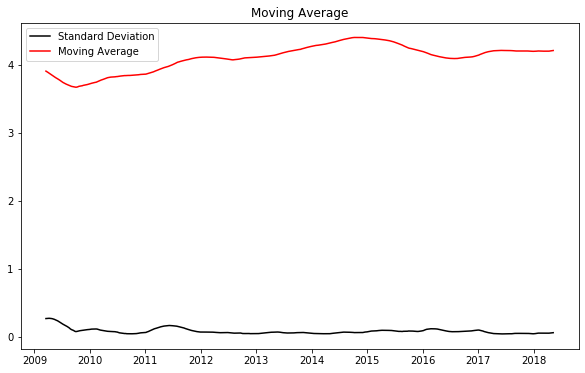

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log2 = np.log(df_close2)
#rolling statistics
moving_avg = df_log2.rolling(52).mean()
std_dev = df_log2.rolling(52).std()
#graph for moving average and standard deviation
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Moving Average")
plt.legend()
plt.show()

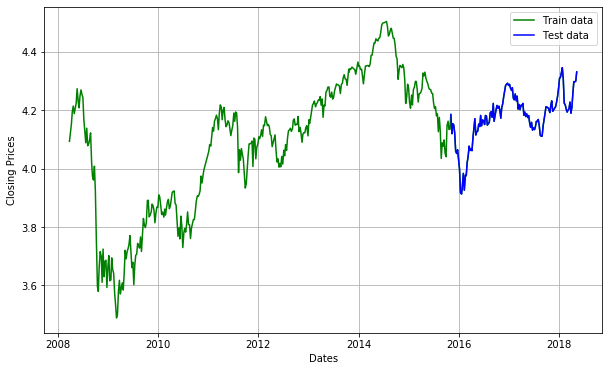

In [74]:
#splitting data into test and training set
#the order sequence of the time series should be intact in order to use it for forecasting.

train_data = df_log2[:int(len(df_log2)*0.75)] #training set containing 75% of the data starting from day 1
test_data= df_log2[int(len(df_log2)*0.75):] #test set containing 25% of the data excluding the training set

#plot train set and test set
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log2, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


In [75]:
#autoARIMA-Auto Rgressive Integrated Moving Average
#Returns best ARIMA model according to either AIC, AICc or BIC value.

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use ADF test to find optimal 'd' using constraints
                      max_p=3, max_q=3, # maximum p and q where p=order of AR term and q=order of MA term
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd' which is the number of differencing required to make the time series stationary
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1467.240, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1466.416, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1466.580, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1469.236, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1463.425, Time=0.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.276 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  393
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 735.618
Date:                Thu, 08 Oct 2020   AIC                          -1469.236
Time:                        03:25:37   BIC                          -1465.265
Sample:                             0   HQIC                         -1467.662
                                - 393                                  

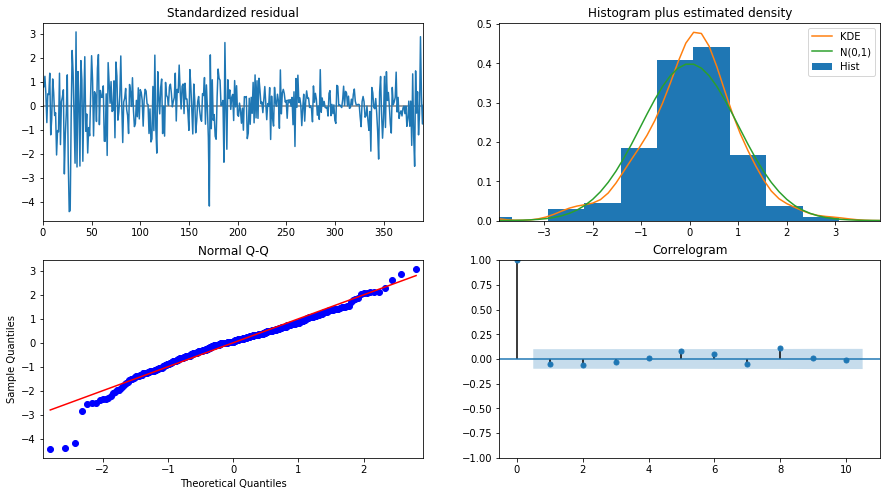

In [76]:
#plot autoARIMA
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [77]:
#ARIMA model applied on train data
model = ARIMA(train_data, order=(0, 1, 0)) #values of p,q and d to be used in ARIMA function evaluated with the help of autoARIMA 
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  392
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 735.620
Method:                           css   S.D. of innovations              0.037
Date:                Thu, 08 Oct 2020   AIC                          -1467.240
Time:                        03:25:38   BIC                          -1459.297
Sample:                             1   HQIC                         -1464.092
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.002      0.056      0.955      -0.004       0.004


C:\Users\Chandra Sen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Chandra Sen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


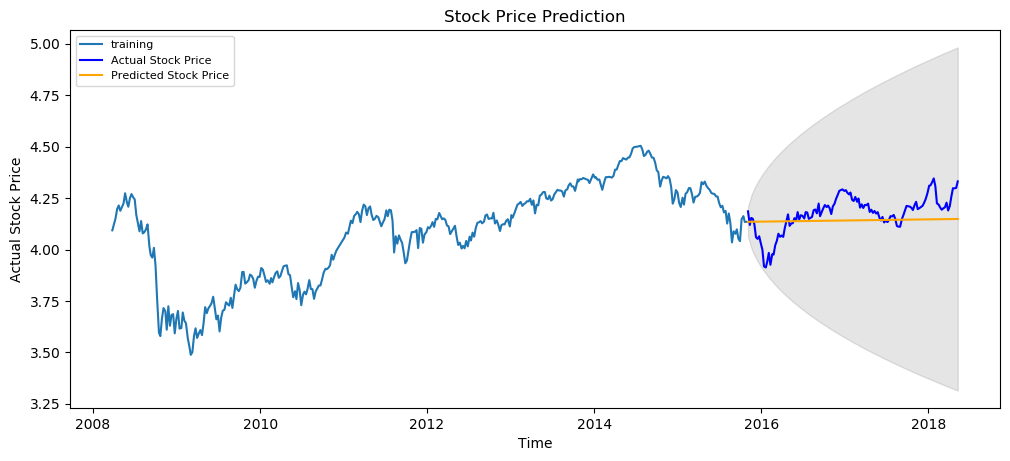

In [78]:
# Forecasting Stock Price
fc, se, conf = fitted.forecast(132, alpha=0.05)  #95% confidence level
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

#plotting the actual and forecasted price based on train data and test data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [79]:
# report performance based on test data and forecasted values

mse = mean_squared_error(test_data, fc) #Mean Squared Error
print('MSE: '+str(mse)) 
mae = mean_absolute_error(test_data, fc) #Mean Absolute Error
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc)) #Root Mean squared Error
print('RMSE: '+str(rmse)) 
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data)) #Mean Absolute Percentage Error
print('MAPE: '+str(mape)) 

MSE: 0.008140958728664967
MAE: 0.0724230835297861
RMSE: 0.09022726156026774
MAPE: 0.017336088815531007


In [80]:
#The value of MAPE is 0.017 which means the model is 98.3 % accurate in predicting the stock prices.